In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from time import time
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgbm
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


import category_encoders as ce
from sklearn.metrics import classification_report, log_loss, accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv('music_genre-3.csv')
data

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50000,58878.0,BEXEY,GO GETTA,59.0,0.03340,0.913,-1.0,0.574,0.00000,C#,0.119,-7.022,Major,0.2980,98.02799999999999,4-Apr,0.330,Hip-Hop
50001,43557.0,Roy Woods,Drama (feat. Drake),72.0,0.15700,0.709,251860.0,0.362,0.00000,B,0.109,-9.814,Major,0.0550,122.04299999999999,4-Apr,0.113,Hip-Hop
50002,39767.0,Berner,Lovin' Me (feat. Smiggz),51.0,0.00597,0.693,189483.0,0.763,0.00000,D,0.143,-5.443,Major,0.1460,131.079,4-Apr,0.395,Hip-Hop
50003,57944.0,The-Dream,Shawty Is Da Shit,65.0,0.08310,0.782,262773.0,0.472,0.00000,G,0.106,-5.016,Minor,0.0441,75.88600000000001,4-Apr,0.354,Hip-Hop


In [3]:
data.shape

(50005, 18)

In [4]:
data.duplicated().any()
duplicated = data.duplicated

In [5]:
data[duplicated]

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
data.iloc[9999:10006]

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
9999,41509.0,Hachioji P,Yeah! Yeah!! Yeah!!!,14.0,0.02000,0.573,226374.0,0.921,0.000004,F#,0.325,-3.841,Major,0.0734,135.029,4-Apr,0.599,Anime
10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10005,77089.0,Blockhead,"Cheer up, You're Not Dead Yet",44.0,0.00621,0.711,285987.0,0.621,0.029700,G,0.159,-7.429,Major,0.0382,142.065,4-Apr,0.607,Jazz


In [7]:
data.drop([1000, 1001, 1002, 1003, 1004], inplace = True)

In [8]:
df_music = data.dropna()

In [9]:
df_music.isnull().any()

instance_id         False
artist_name         False
track_name          False
popularity          False
acousticness        False
danceability        False
duration_ms         False
energy              False
instrumentalness    False
key                 False
liveness            False
loudness            False
mode                False
speechiness         False
tempo               False
obtained_date       False
valence             False
music_genre         False
dtype: bool

In [10]:
df_music.shape

(49995, 18)

In [11]:
len(df_music["instance_id"].unique()) 

49995

In [12]:
len(df_music["artist_name"].unique())

6863

In [13]:
df_music["key"].unique()

array(['A#', 'D', 'G#', 'C#', 'F#', 'B', 'G', 'F', 'A', 'C', 'E', 'D#'],
      dtype=object)

In [14]:
df_music["mode"].unique()

array(['Minor', 'Major'], dtype=object)

In [15]:
df_music["obtained_date"].unique() 

array(['4-Apr', '3-Apr', '5-Apr', '1-Apr', '0/4'], dtype=object)

In [16]:
df_music["music_genre"].unique()

array(['Electronic', 'Anime', 'Jazz', 'Alternative', 'Country', 'Rap',
       'Blues', 'Rock', 'Classical', 'Hip-Hop'], dtype=object)

In [17]:
df_music.reset_index(inplace = True)

In [18]:
df_music= df_music.drop(["index", "instance_id", "track_name", "obtained_date"], axis = 1)

In [19]:
df_music.head()

,artist_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,Röyksopp,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,0.759,Electronic
1,Thievery Corporation,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,0.531,Electronic
2,Dillon Francis,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,0.333,Electronic
3,Dubloadz,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,0.270,Electronic
4,What So Not,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,0.323,Electronic


In [20]:
df_music[df_music["artist_name"] == "empty_field"]

,artist_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
19,empty_field,50.0,0.02810,0.656,307328.0,0.653,0.858000,F#,0.1120,-11.883,Minor,0.0396,117.999,0.1990,Electronic
25,empty_field,34.0,0.02360,0.715,221050.0,0.978,0.000493,D,0.2160,-1.538,Major,0.3620,125.109,0.4180,Electronic
44,empty_field,31.0,0.00350,0.595,222147.0,0.904,0.003780,D,0.0533,-6.805,Minor,0.0349,127.61,0.8410,Electronic
128,empty_field,32.0,0.01390,0.498,-1.0,0.945,0.647000,F,0.3380,-0.003,Minor,0.1370,149.888,0.1790,Electronic
135,empty_field,44.0,0.15300,0.792,265133.0,0.549,0.379000,F,0.3430,-9.855,Major,0.0456,120.01299999999999,0.4760,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49932,empty_field,50.0,0.05480,0.754,132414.0,0.840,0.000014,A,0.1500,-5.111,Major,0.3130,144.991,0.0397,Hip-Hop
49946,empty_field,52.0,0.13300,0.867,-1.0,0.618,0.000002,B,0.1280,-4.956,Minor,0.0614,140.005,0.8570,Hip-Hop
49961,empty_field,51.0,0.12400,0.786,187027.0,0.738,0.000000,C,0.1400,-5.621,Major,0.3890,93.758,0.7800,Hip-Hop
49981,empty_field,53.0,0.00392,0.770,211820.0,0.905,0.000003,F,0.1690,-8.235,Minor,0.1440,135.999,0.4640,Hip-Hop


In [21]:
artists = df_music["artist_name"].value_counts()[:20].sort_values(ascending = True)
artists

artist_name
Ryuichi Sakamoto              90
$uicideBoy$                   92
Logic                         92
Howard Shore                  93
Mac Miller                    97
Kevin Gates                  102
Pyotr Ilyich Tchaikovsky     103
The Black Keys               114
Thievery Corporation         122
Future                       124
Eminem                       147
Yuki Hayashi                 167
Capcom Sound Team            169
Drake                        172
Frédéric Chopin              241
Johann Sebastian Bach        314
Ludwig van Beethoven         317
Wolfgang Amadeus Mozart      402
Nobuo Uematsu                429
empty_field                 2489
Name: count, dtype: int64

In [22]:
df_music = df_music.drop(df_music[df_music["artist_name"] == "empty_field"].index)

In [23]:
df_music.drop("artist_name", axis = 1, inplace = True)

In [24]:
df_music

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,0.759,Electronic
1,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,0.531,Electronic
2,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,0.333,Electronic
3,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,0.270,Electronic
4,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,0.323,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49990,59.0,0.03340,0.913,-1.0,0.574,0.00000,C#,0.119,-7.022,Major,0.2980,98.02799999999999,0.330,Hip-Hop
49991,72.0,0.15700,0.709,251860.0,0.362,0.00000,B,0.109,-9.814,Major,0.0550,122.04299999999999,0.113,Hip-Hop
49992,51.0,0.00597,0.693,189483.0,0.763,0.00000,D,0.143,-5.443,Major,0.1460,131.079,0.395,Hip-Hop
49993,65.0,0.08310,0.782,262773.0,0.472,0.00000,G,0.106,-5.016,Minor,0.0441,75.88600000000001,0.354,Hip-Hop


In [25]:
df_music[df_music["tempo"] == "?"]

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
5,47.0,0.00523,0.755,519468.0,0.731,0.854000,D,0.2160,-10.517,Minor,0.0412,?,0.6140,Electronic
32,45.0,0.02330,0.729,274286.0,0.869,0.585000,F,0.0944,-7.569,Minor,0.1290,?,0.1380,Electronic
35,33.0,0.10800,0.493,-1.0,0.682,0.000000,A,0.1960,-5.781,Minor,0.2870,?,0.2390,Electronic
36,45.0,0.04780,0.646,253333.0,0.649,0.002520,G,0.3530,-5.259,Major,0.1170,?,0.7270,Electronic
39,37.0,0.20300,0.769,429941.0,0.551,0.882000,A#,0.1090,-12.520,Minor,0.0408,?,0.0618,Electronic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49908,58.0,0.29600,0.379,292520.0,0.644,0.000000,A#,0.3130,-7.933,Minor,0.1120,?,0.1440,Hip-Hop
49954,59.0,0.08470,0.929,215200.0,0.737,0.000000,G#,0.8610,-6.424,Major,0.1020,?,0.8860,Hip-Hop
49957,62.0,0.17900,0.860,233293.0,0.625,0.000136,D,0.3000,-6.922,Major,0.1050,?,0.2210,Hip-Hop
49966,52.0,0.70000,0.462,225067.0,0.741,0.000000,A#,0.3400,-8.008,Minor,0.1620,?,0.5890,Hip-Hop


In [26]:
df_music= df_music.drop(df_music[df_music["tempo"] == "?"].index)

In [27]:
df_music["tempo"] = df_music["tempo"].astype("float")
df_music["tempo"] = np.around(df_music["tempo"], decimals = 2)

In [28]:
from sklearn.preprocessing import LabelEncoder
key_encoder = LabelEncoder()

df_music["key"] = key_encoder.fit_transform(df_music["key"])

In [29]:
df_music.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,27.0,0.00468,0.652,-1.0,0.941,0.79200,1,0.115,-5.201,Minor,0.0748,100.89,0.759,Electronic
1,31.0,0.01270,0.622,218293.0,0.890,0.95000,5,0.124,-7.043,Minor,0.0300,115.00,0.531,Electronic
2,28.0,0.00306,0.620,215613.0,0.755,0.01180,11,0.534,-4.617,Major,0.0345,127.99,0.333,Electronic
3,34.0,0.02540,0.774,166875.0,0.700,0.00253,4,0.157,-4.498,Major,0.2390,128.01,0.270,Electronic
4,32.0,0.00465,0.638,222369.0,0.587,0.90900,9,0.157,-6.266,Major,0.0413,145.04,0.323,Electronic


In [30]:
key_encoder.classes_

array(['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#'],
      dtype=object)

In [31]:
mode_encoder = LabelEncoder()
df_music["mode"] = mode_encoder.fit_transform(df_music["mode"])
df_music.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,27.0,0.00468,0.652,-1.0,0.941,0.79200,1,0.115,-5.201,1,0.0748,100.89,0.759,Electronic
1,31.0,0.01270,0.622,218293.0,0.890,0.95000,5,0.124,-7.043,1,0.0300,115.00,0.531,Electronic
2,28.0,0.00306,0.620,215613.0,0.755,0.01180,11,0.534,-4.617,0,0.0345,127.99,0.333,Electronic
3,34.0,0.02540,0.774,166875.0,0.700,0.00253,4,0.157,-4.498,0,0.2390,128.01,0.270,Electronic
4,32.0,0.00465,0.638,222369.0,0.587,0.90900,9,0.157,-6.266,0,0.0413,145.04,0.323,Electronic


In [32]:
df_music.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence
count,42786.000000,42786.000000,42786.000000,4.278600e+04,42786.000000,42786.000000,42786.000000,42786.000000,42786.000000,42786.000000,42786.000000,42786.000000,42786.000000
mean,44.254172,0.306120,0.558737,2.210717e+05,0.599986,0.181913,5.353714,0.193999,-9.124488,0.358809,0.093787,119.958186,0.456559
std,15.555059,0.341035,0.178840,1.271053e+05,0.264106,0.325782,3.462552,0.161709,6.142095,0.479657,0.101285,30.666741,0.247187
min,0.000000,0.000000,0.059600,-1.000000e+00,0.000792,0.000000,0.000000,0.009670,-47.046000,0.000000,0.022300,34.350000,0.000000
25%,34.000000,0.020100,0.442250,1.747365e+05,0.433000,0.000000,3.000000,0.096900,-10.844500,0.000000,0.036100,94.922500,0.258000
50%,45.000000,0.145000,0.569000,2.194000e+05,0.642000,0.000161,5.000000,0.126000,-7.283000,0.000000,0.049000,119.900000,0.448000
75%,56.000000,0.551000,0.687000,2.685870e+05,0.816000,0.155000,8.000000,0.244000,-5.180000,1.000000,0.099100,140.490000,0.648000
max,99.000000,0.996000,0.986000,4.497994e+06,0.999000,0.996000,11.000000,1.000000,3.744000,1.000000,0.942000,220.280000,0.992000


In [33]:
mode_encoder.classes_

array(['Major', 'Minor'], dtype=object)

In [34]:
music_features = df_music.drop("music_genre", axis = 1)
music_labels = df_music["music_genre"]

In [35]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(music_features , music_labels, test_size = 0.3, random_state=42)

In [36]:
clf = DecisionTreeClassifier()

# Train the classifier on the training data
clf.fit(X_train, y_train)

# Get feature names after one-hot encoding
feature_names = music_features.columns

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}\n")

# Feature Importance
feature_importance_dt = clf.feature_importances_

# Sort feature importance in descending order
sorted_feature_importance = sorted(zip(feature_names, feature_importance_dt), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance scores
print("Feature Importance:\n")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Accuracy: 0.4319102524150826
Precision: 0.431310467481951
Recall: 0.4319102524150826

Feature Importance:

popularity: 0.19888914435437938
loudness: 0.12374148190652876
speechiness: 0.09941971487606538
danceability: 0.0891396200053098
acousticness: 0.07906791420085812
instrumentalness: 0.07846226971150017
valence: 0.06961593844213883
energy: 0.06293282646887262
duration_ms: 0.0607660858325327
tempo: 0.05486489689166421
liveness: 0.045263422319290314
key: 0.028004908658961658
mode: 0.009831776331898303


In [37]:
df_dt_results = pd.DataFrame({
    'Evaluation': ['Accuracy', 'Precision', 'Recall'],
    'Score': [accuracy, precision, recall]
})
print(df_dt_results)

  Evaluation    Score
0   Accuracy  0.43191
1  Precision  0.43131
2     Recall  0.43191


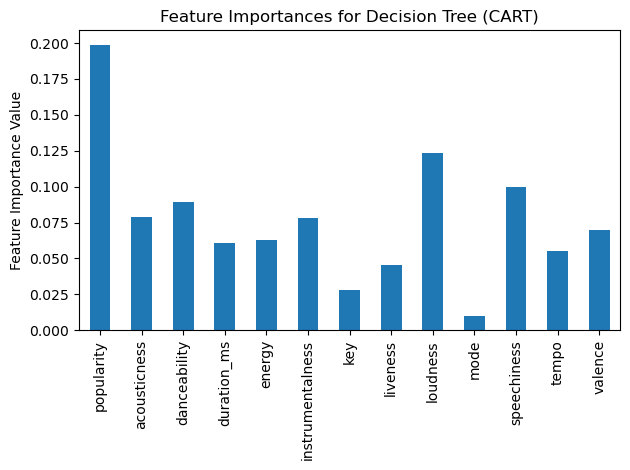

In [38]:
plotted_feature_importance_dt = pd.Series(feature_importance_dt, index = feature_names)
fig, ax = plt.subplots()
plotted_feature_importance_dt.plot.bar(ax=ax)
ax.set_title("Feature Importances for Decision Tree (CART)")
ax.set_ylabel("Feature Importance Value")
fig.tight_layout()

In [39]:
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust hyperparameters as needed

# Train the classifier on the training data
clf_rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf_rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}\n")

# Feature Importance
feature_importance_rf = clf_rf.feature_importances_

# Sort feature importance in descending order
sorted_feature_importance = sorted(zip(feature_names, feature_importance_rf), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance scores
print("Feature Importance:\n")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Accuracy: 0.5524306637581802
Precision: 0.5548114376657682
Recall: 0.5524306637581802

Feature Importance:

popularity: 0.18055805525000274
speechiness: 0.09442289402552398
loudness: 0.0924738868772391
danceability: 0.09162868895321033
acousticness: 0.08900983755259206
instrumentalness: 0.08247703145859428
energy: 0.0797329229430582
valence: 0.07111224518849715
duration_ms: 0.063002203346257
tempo: 0.05747471276739817
liveness: 0.05220521520424102
key: 0.03455073942097299
mode: 0.011351567012412871


In [40]:
df_dt_results = pd.DataFrame({
    'Evaluation': ['Accuracy', 'Precision', 'Recall'],
    'Score': [accuracy, precision, recall]
})
print(df_dt_results)

  Evaluation     Score
0   Accuracy  0.552431
1  Precision  0.554811
2     Recall  0.552431


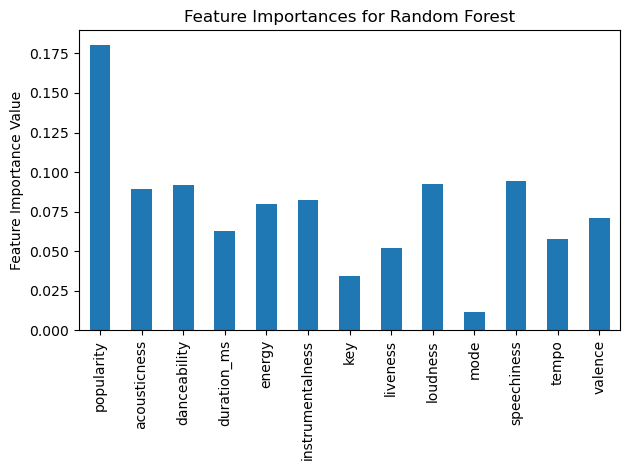

In [41]:
plotted_feature_importance_rf = pd.Series(feature_importance_rf, index = feature_names)
fig, ax = plt.subplots()
plotted_feature_importance_rf.plot.bar(ax=ax)
ax.set_title("Feature Importances for Random Forest")
ax.set_ylabel("Feature Importance Value")
fig.tight_layout()

In [42]:
clf_stump = DecisionTreeClassifier(max_depth = 1)

# Train the classifier on the training data
clf_stump.fit(X_train, y_train)

# Get feature names after one-hot encoding
feature_names = music_features.columns

# Make predictions on the testing data
y_pred = clf_stump.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}\n")

# Feature Importance
feature_importance_stump = clf_stump.feature_importances_

# Sort feature importance in descending order
sorted_feature_importance = sorted(zip(feature_names, feature_importance_stump), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance scores
print("Feature Importance:\n")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Accuracy: 0.2004518541601745
Precision: 0.04132645362800355
Recall: 0.2004518541601745

Feature Importance:

popularity: 1.0
acousticness: 0.0
danceability: 0.0
duration_ms: 0.0
energy: 0.0
instrumentalness: 0.0
key: 0.0
liveness: 0.0
loudness: 0.0
mode: 0.0
speechiness: 0.0
tempo: 0.0
valence: 0.0


/Users/luabeyakabongo/anaconda3/envs/dataMiningClass/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
df_dt_results = pd.DataFrame({
    'Evaluation': ['Accuracy', 'Precision', 'Recall'],
    'Score': [accuracy, precision, recall]
})
print(df_dt_results)

  Evaluation     Score
0   Accuracy  0.200452
1  Precision  0.041326
2     Recall  0.200452


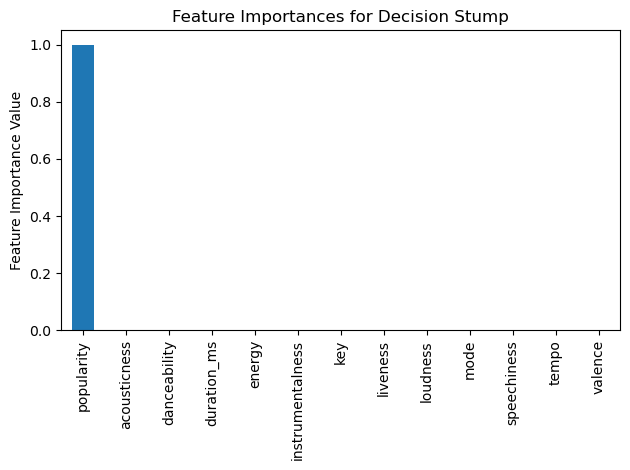

In [44]:
plotted_feature_importance_stump = pd.Series(feature_importance_stump, index = feature_names)
fig, ax = plt.subplots()
plotted_feature_importance_stump.plot.bar(ax=ax)
ax.set_title("Feature Importances for Decision Stump")
ax.set_ylabel("Feature Importance Value")
fig.tight_layout()

In [45]:
class_names=sorted(df_music['music_genre'].unique().tolist())
print(class_names)
M=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,M)) 
reverse_mapping=dict(zip(M,class_names))       
df_music['music_genre']=df_music['music_genre'].map(normal_mapping)

random.seed(2023)
N=list(range(len(df_music)))
random.shuffle(N)
df_music=df_music.iloc[N]

['Alternative', 'Anime', 'Blues', 'Classical', 'Country', 'Electronic', 'Hip-Hop', 'Jazz', 'Rap', 'Rock']


In [46]:
from sklearn.preprocessing import LabelEncoder

def labelencoder(df):
    for c in df.columns:
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
    return df

In [47]:
df_music=labelencoder(df_music)
display(df_music)

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
48580,54.0,0.12100,0.758,321507.0,0.8450,0.000000,5,0.3280,-8.021,0,0.2720,76.88,0.944,6
31363,25.0,0.45100,0.860,211213.0,0.5270,0.000005,3,0.0904,-7.478,0,0.0452,109.54,0.786,2
40783,31.0,0.99200,0.276,368222.0,0.0025,0.913000,4,0.0945,-40.563,1,0.0394,73.34,0.120,3
13993,36.0,0.75300,0.640,185480.0,0.5300,0.833000,7,0.0960,-14.939,1,0.0493,90.16,0.291,7
41244,28.0,0.99500,0.628,90471.0,0.4110,0.888000,3,0.1180,-11.071,0,0.1040,152.44,0.982,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46824,47.0,0.00131,0.820,182067.0,0.9000,0.000000,2,0.1890,-7.256,1,0.0976,123.00,0.365,6
24549,47.0,0.12600,0.657,-1.0,0.6820,0.000004,2,0.0436,-5.251,0,0.0407,138.04,0.161,4
29846,61.0,0.00142,0.449,327787.0,0.8130,0.000172,11,0.1060,-5.478,0,0.1290,177.96,0.452,8
34272,23.0,0.00219,0.338,-1.0,0.9450,0.746000,5,0.1570,-3.875,0,0.0753,102.90,0.311,2


In [48]:
music_features = df_music.drop("music_genre", axis = 1)
music_labels = df_music["music_genre"]

In [49]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(music_features , music_labels, test_size = 0.3, random_state=42)

In [50]:
clf_boost1 = xgb.XGBClassifier(objective='multi:softmax', num_class=10, random_state=42)

# Train the classifier on the training data
clf_boost1.fit(X_train, y_train)

# Get feature names after one-hot encoding
feature_names = music_features.columns

# Make predictions on the testing data
y_pred = clf_boost1.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}\n")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importance_boost1 = clf_boost1.feature_importances_

# Sort feature importance in descending order
sorted_feature_importance = sorted(zip(feature_names, feature_importance_boost1), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance scores
print("Feature Importance:\n")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Accuracy: 0.5719850420691804
Precision: 0.576736678841173
Recall: 0.5719850420691804

Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.39      0.42      1248
           1       0.81      0.75      0.78      1277
           2       0.64      0.55      0.59      1325
           3       0.85      0.85      0.85      1293
           4       0.60      0.59      0.59      1277
           5       0.63      0.63      0.63      1288
           6       0.36      0.38      0.37      1270
           7       0.57      0.53      0.55      1312
           8       0.34      0.35      0.34      1232
           9       0.52      0.68      0.59      1314

    accuracy                           0.57     12836
   macro avg       0.58      0.57      0.57     12836
weighted avg       0.58      0.57      0.57     12836

Feature Importance:

popularity: 0.27417516708374023
loudness: 0.11304663121700287
instrumentalness: 0.09606664627790451
speechiness

In [51]:
df_dt_results = pd.DataFrame({
    'Evaluation': ['Accuracy', 'Precision', 'Recall'],
    'Score': [accuracy, precision, recall]
})
print(df_dt_results)

  Evaluation     Score
0   Accuracy  0.571985
1  Precision  0.576737
2     Recall  0.571985


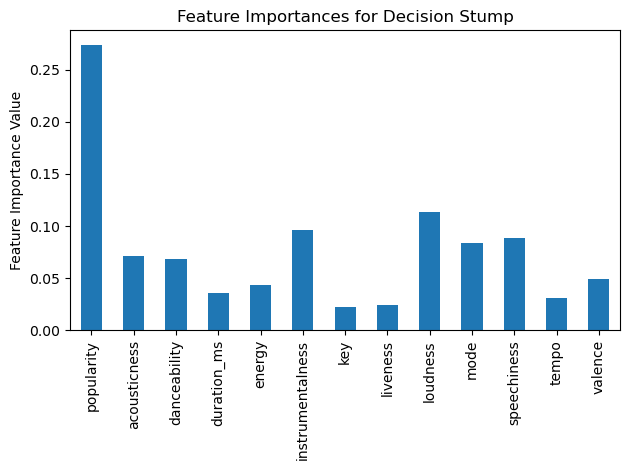

In [52]:
plotted_feature_importance_boost1 = pd.Series(feature_importance_boost1, index = feature_names)
fig, ax = plt.subplots()
plotted_feature_importance_boost1.plot.bar(ax=ax)
ax.set_title("Feature Importances for Decision Stump")
ax.set_ylabel("Feature Importance Value")
fig.tight_layout()

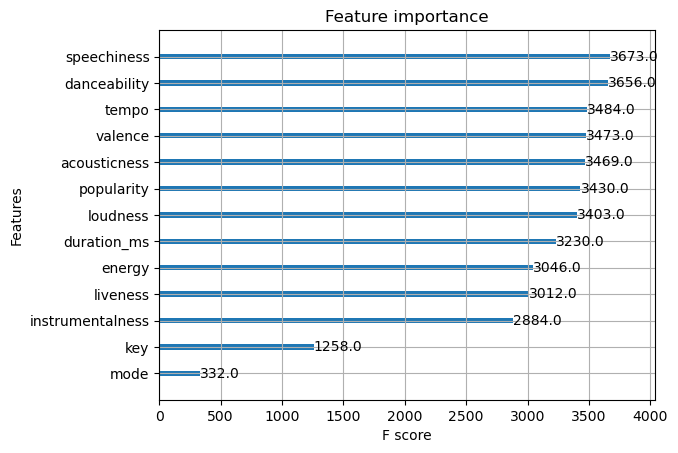

In [53]:
# Plot feature importance
xgb.plot_importance(clf_boost1)
plt.show()

In [54]:
from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(music_features , music_labels , test_size=0.3, stratify = music_labels, random_state = 7)

In [55]:
clf_boost2 = xgb.XGBClassifier(objective='multi:softmax', n_estimators = 101, random_state=42, learning_rate = 0.1)

# Train the classifier on the training data
clf_boost2.fit(X_train, y_train)

# Get feature names after one-hot encoding
feature_names = music_features.columns

# Make predictions on the testing data
y_pred = clf_boost1.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}\n")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importance_boost2 = clf_boost2.feature_importances_

# Sort feature importance in descending order
sorted_feature_importance = sorted(zip(feature_names, feature_importance_boost2), key=lambda x: x[1], reverse=True)

# Print the sorted feature importance scores
print("Feature Importance:\n")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Accuracy: 0.769788095980056
Precision: 0.774093230001049
Recall: 0.769788095980056

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.61      0.65      1274
           1       0.93      0.89      0.91      1276
           2       0.82      0.75      0.78      1272
           3       0.95      0.92      0.93      1277
           4       0.75      0.78      0.76      1287
           5       0.82      0.80      0.81      1279
           6       0.66      0.68      0.67      1291
           7       0.79      0.75      0.77      1296
           8       0.64      0.69      0.66      1281
           9       0.68      0.82      0.75      1303

    accuracy                           0.77     12836
   macro avg       0.77      0.77      0.77     12836
weighted avg       0.77      0.77      0.77     12836

Feature Importance:

popularity: 0.2761857211589813
loudness: 0.1436278074979782
instrumentalness: 0.10014842450618744
speechiness: 0.

In [56]:
df_dt_results = pd.DataFrame({
    'Evaluation': ['Accuracy', 'Precision', 'Recall'],
    'Score': [accuracy, precision, recall]
})
print(df_dt_results)

  Evaluation     Score
0   Accuracy  0.769788
1  Precision  0.774093
2     Recall  0.769788


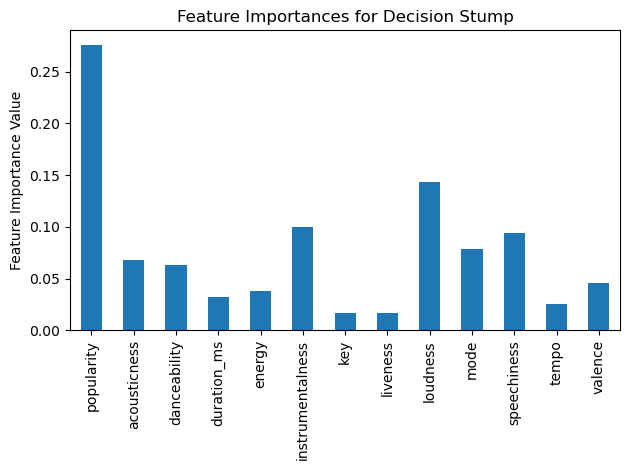

In [57]:
plotted_feature_importance_boost2 = pd.Series(feature_importance_boost2, index = feature_names)
fig, ax = plt.subplots()
plotted_feature_importance_boost2.plot.bar(ax=ax)
ax.set_title("Feature Importances for Decision Stump")
ax.set_ylabel("Feature Importance Value")
fig.tight_layout()

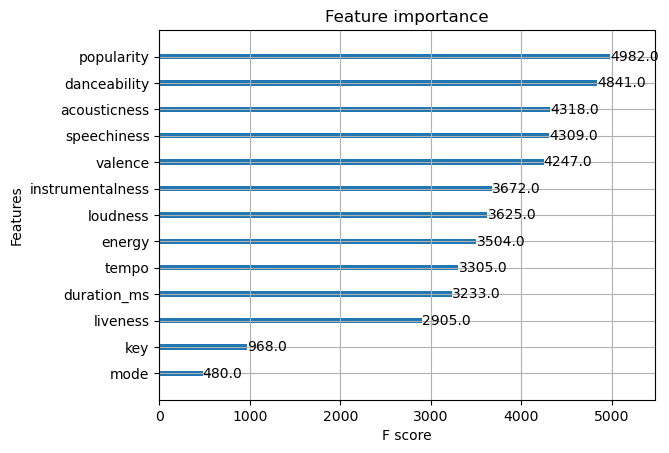

In [58]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(clf_boost2)
plt.show()